# Predictive Maintenance for Machinery 

In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import GridSearchCV
import joblib
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Load the dataset
file_path = 'predictive_maintenance_dataset.csv'
data = pd.read_csv(file_path)

# Inspect missing values
print("\nMissing Values Summary:")
print(data.isnull().sum())

# Convert 'date' column to datetime
data['date'] = pd.to_datetime(data['date'], errors='coerce')

# Check for invalid date conversions
invalid_dates = data['date'].isna().sum()
print(f"\nInvalid date entries converted to NaT: {invalid_dates}")

# Drop rows with invalid dates if necessary
data.dropna(subset=['date'], inplace=True)

# Inspect data types
print("\nData Types:")
print(data.dtypes)

# Summary statistics for numeric columns
print("\nSummary Statistics:")
print(data.describe())



Missing Values Summary:
date       0
device     0
failure    0
metric1    0
metric2    0
metric3    0
metric4    0
metric5    0
metric6    0
metric7    0
metric8    0
metric9    0
dtype: int64

Invalid date entries converted to NaT: 0

Data Types:
date       datetime64[ns]
device             object
failure             int64
metric1             int64
metric2             int64
metric3             int64
metric4             int64
metric5             int64
metric6             int64
metric7             int64
metric8             int64
metric9             int64
dtype: object

Summary Statistics:
                                date        failure       metric1  \
count                         124494  124494.000000  1.244940e+05   
mean   2015-04-16 05:20:49.737337088       0.000851  1.223881e+08   
min              2015-01-01 00:00:00       0.000000  0.000000e+00   
25%              2015-02-09 00:00:00       0.000000  6.128476e+07   
50%              2015-03-27 00:00:00       0.000000  1.2279

C:\Users\milto\AppData\Local\Temp\ipykernel_22288\2137433947.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='failure', data=data, palette='viridis')


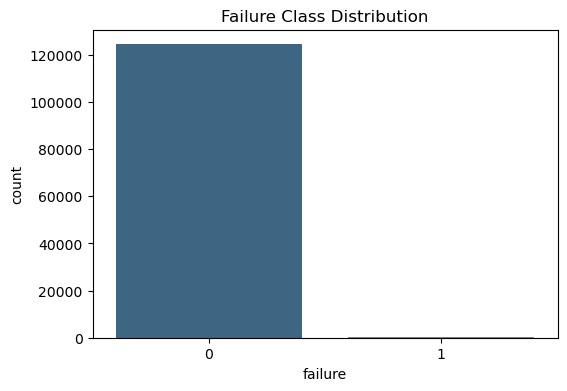

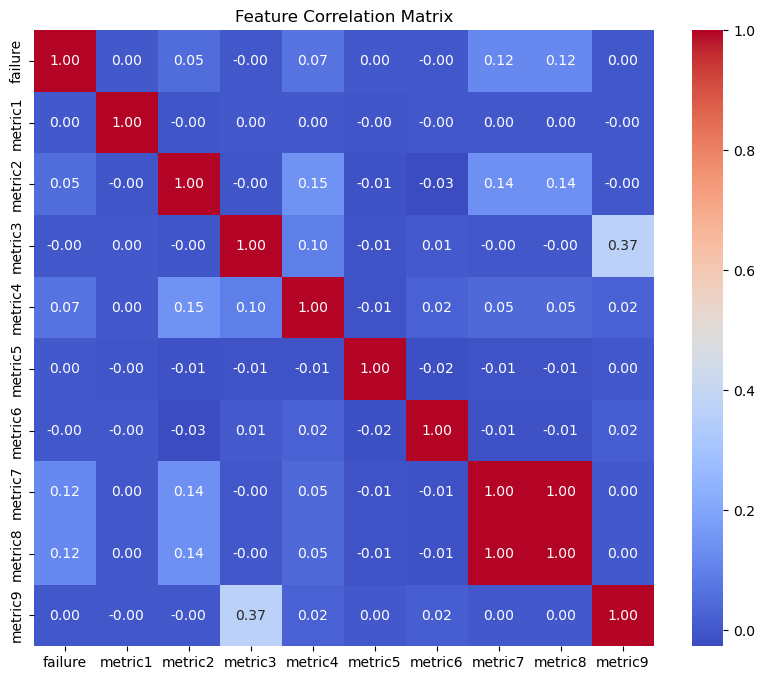

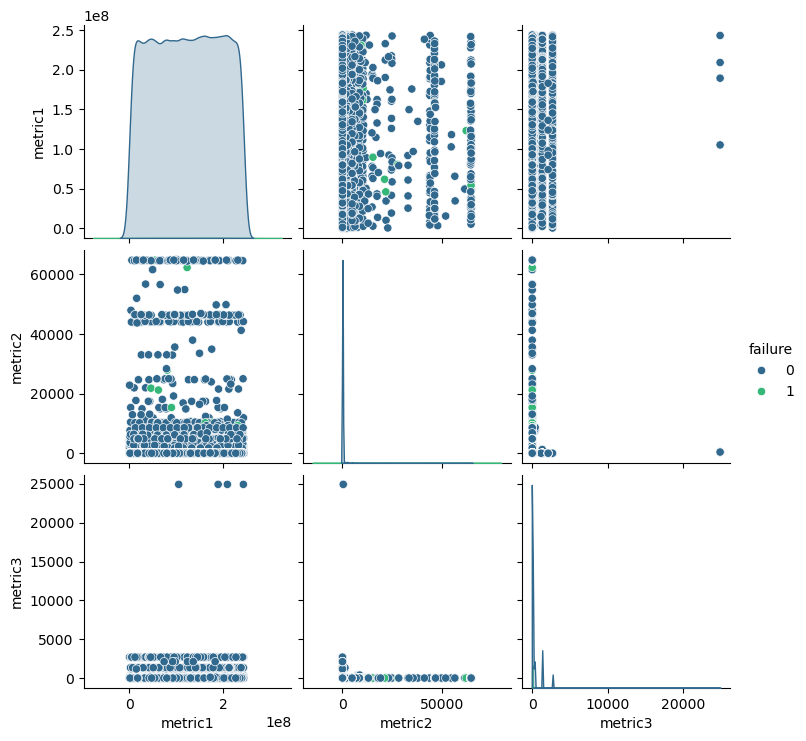

In [4]:
# Exploratory Data Analysis (EDA)

# Distribution of target variable
plt.figure(figsize=(6, 4))
sns.countplot(x='failure', data=data, palette='viridis')
plt.title("Failure Class Distribution")
plt.show()

# Select only numeric columns for correlation
numeric_data = data.select_dtypes(include=['float64', 'int64'])

# Correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(numeric_data.corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Feature Correlation Matrix")
plt.show()

# Pairplot of selected features
selected_features = ['metric1', 'metric2', 'metric3', 'failure']
sns.pairplot(data[selected_features], hue='failure', palette='viridis')
plt.show()


In [5]:
# Feature Engineering

# Drop irrelevant columns and handle 'date'
data.drop(columns=['device', 'date'], inplace=True)

# Separate features and target
X = data.drop(columns=['failure'])
y = data['failure']

# Train-test split with stratification to maintain class balance
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Scale features (for models sensitive to feature scale)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Check class distribution
print("\nTraining Set Class Distribution:")
print(y_train.value_counts(normalize=True))


Training Set Class Distribution:
failure
0    0.999147
1    0.000853
Name: proportion, dtype: float64


In [6]:
# Address Class Imbalance with SMOTE

# Apply SMOTE for balancing
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_scaled, y_train)

# Check class distribution after SMOTE
print("\nBalanced Class Distribution (After SMOTE):")
print(pd.Series(y_train_balanced).value_counts())

# Optional: Inspect the first few samples of the balanced data
balanced_df = pd.DataFrame(X_train_balanced, columns=X.columns)  # Recreate column names for inspection
balanced_df['failure'] = y_train_balanced
print("\nSample of Balanced Dataset:")
print(balanced_df.head())


Balanced Class Distribution (After SMOTE):
failure
0    99510
1    99510
Name: count, dtype: int64

Sample of Balanced Dataset:
    metric1   metric2   metric3   metric4   metric5   metric6  metric7  \
0 -0.510219 -0.073798 -0.055313 -0.078089  2.741290 -0.149262 -0.03669   
1 -1.130733 -0.073798 -0.055313 -0.078089  0.110314 -2.623479 -0.03669   
2 -0.043286  0.117074 -0.055313 -0.078089 -0.265540  0.096618 -0.03669   
3  0.320230 -0.073798 -0.055313 -0.078089 -0.328182 -0.638773 -0.03669   
4 -1.187116 -0.073798 -0.055313 -0.078089 -0.390825  1.029733 -0.03669   

   metric8   metric9  failure  
0 -0.03669 -0.046233        0  
1 -0.03669 -0.046233        0  
2 -0.03669 -0.046233        0  
3 -0.03669 -0.046233        0  
4 -0.03669 -0.003483        0  



Cross-Validation Results:
test_accuracy: 0.9993 ± 0.0006
test_roc_auc: 1.0000 ± 0.0000

Test Set Evaluation:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     24878
           1       0.13      0.10      0.11        21

    accuracy                           1.00     24899
   macro avg       0.57      0.55      0.56     24899
weighted avg       1.00      1.00      1.00     24899

Test ROC-AUC Score: 0.7661

Top Features:
   Feature  Importance
3  metric4    0.281446
1  metric2    0.223327
4  metric5    0.121606
5  metric6    0.097788
0  metric1    0.079438


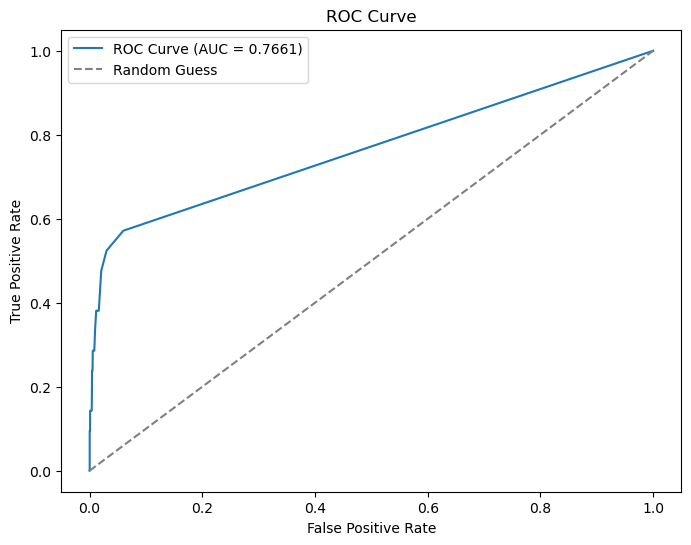

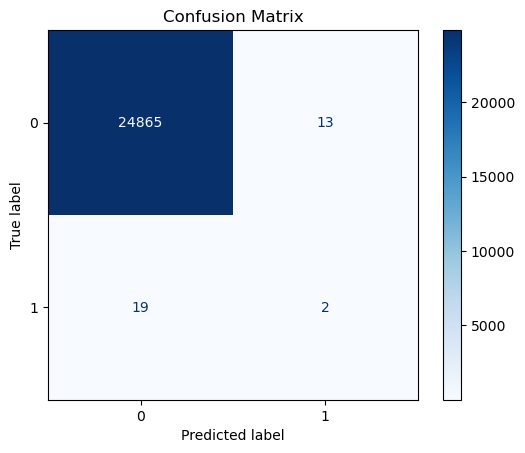

In [7]:
# Model Training and Cross-Validation

# Initialize Random Forest
rf_model = RandomForestClassifier(random_state=42, n_jobs=-1)

# Cross-validation
cv_results = cross_validate(rf_model, X_train_balanced, y_train_balanced, cv=5, scoring=['accuracy', 'roc_auc'])

print("\nCross-Validation Results:")
for metric, scores in cv_results.items():
    if 'test' in metric:
        print(f"{metric}: {np.mean(scores):.4f} ± {np.std(scores):.4f}")

# Train on the balanced dataset
rf_model.fit(X_train_balanced, y_train_balanced)

# Evaluate on the test set
y_pred = rf_model.predict(X_test_scaled)
y_pred_proba = rf_model.predict_proba(X_test_scaled)[:, 1]

print("\nTest Set Evaluation:")
print(classification_report(y_test, y_pred))

# Calculate ROC-AUC
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"Test ROC-AUC Score: {roc_auc:.4f}")

# Feature Importance
feature_importances = rf_model.feature_importances_
feature_names = X.columns
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

print("\nTop Features:")
print(importance_df.head())

# Plot ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Guess')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

# Plot Confusion Matrix
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

C:\Users\milto\AppData\Local\Temp\ipykernel_22288\3225052182.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')


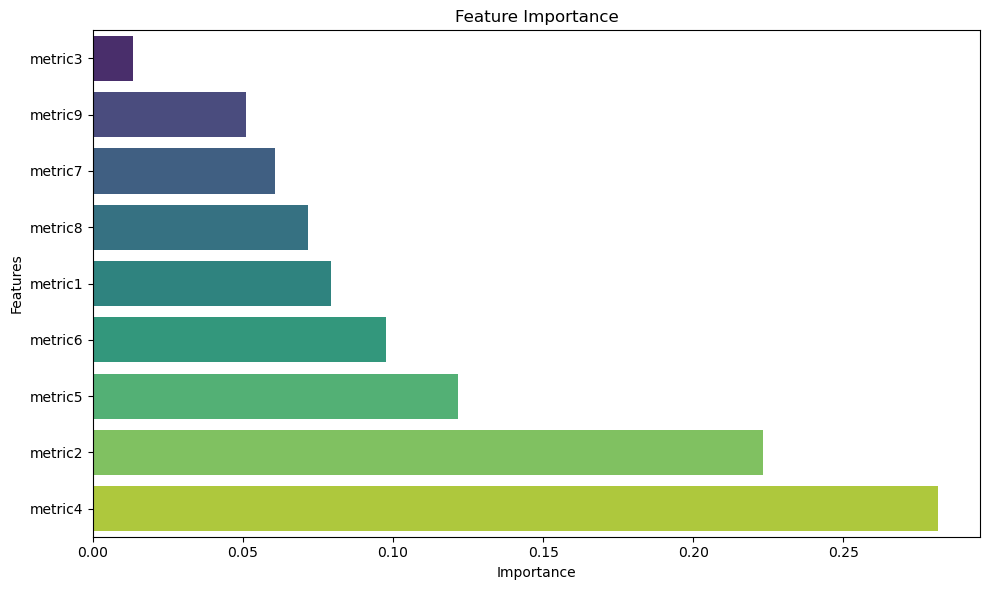

In [11]:
# Feature Importance Analysis

# Ensure that `rf_model` is the trained Random Forest model
importances = rf_model.feature_importances_  # Extract feature importances
features = X.columns  # Extract feature names

# Create a DataFrame for better visualization
importance_df = pd.DataFrame({'Feature': features, 'Importance': importances})
importance_df = importance_df.sort_values(by='Importance', ascending=True)  # Sort for better visualization

# Plot feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')
plt.title("Feature Importance")
plt.xlabel("Importance")
plt.ylabel("Features")
plt.tight_layout()
plt.show()

In [14]:
# Hyperparameter Tuning with Grid Search

# Define parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]
}

# Initialize GridSearchCV
grid_search = GridSearchCV(
    estimator=rf_model, 
    param_grid=param_grid, 
    cv=5, 
    scoring='roc_auc', 
    n_jobs=-1, 
    verbose=1
)

# Fit GridSearchCV on the balanced training data
grid_search.fit(X_train_balanced, y_train_balanced)

# Display the best parameters and score
print("\nBest Parameters from Grid Search:")
print(grid_search.best_params_)

# Get the best model from grid search
best_model = grid_search.best_estimator_

# Inspect Grid Search results
results = pd.DataFrame(grid_search.cv_results_)
print("\nGrid Search Results (Top 5):")
print(results[['param_n_estimators', 'param_max_depth', 'param_min_samples_split', 'mean_test_score']].sort_values(by='mean_test_score', ascending=False).head())

# Evaluate the best model on the test set
y_pred_best = best_model.predict(X_test_scaled)
y_pred_proba_best = best_model.predict_proba(X_test_scaled)[:, 1]

print("\nBest Model Test Evaluation:")
print(classification_report(y_test, y_pred_best))
print(f"Best Model Test ROC-AUC Score: {roc_auc_score(y_test, y_pred_proba_best):.4f}")


Fitting 5 folds for each of 27 candidates, totalling 135 fits

Best Parameters from Grid Search:
{'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}

Grid Search Results (Top 5):
  param_n_estimators param_max_depth param_min_samples_split  mean_test_score
1                200            None                       2         0.999989
2                300            None                       2         0.999988
5                300            None                       5         0.999988
7                200            None                      10         0.999987
8                300            None                      10         0.999987

Best Model Test Evaluation:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     24878
           1       0.13      0.10      0.11        21

    accuracy                           1.00     24899
   macro avg       0.57      0.55      0.56     24899
weighted avg       1.00      1.00      

In [15]:
# Save the best model for future use

joblib.dump(best_model, 'best_rf_model.pkl')
print("\nBest model saved as 'best_rf_model.pkl'")


Best model saved as 'best_rf_model.pkl'
